## Intensity-Modulated Scanning Kelvin Probe Microscopy (IM-SKPM)

A simple package for simulating IM-SKPM in photovoltaics based on conventional charge density recombination ODE. 

This approach simulates equations of the form:

$\frac {dn} {dt} = G-k_1n -k_2n^2-k_3n^3$

where:
* $n$ = carrier density (#$/cm^3$)
* $\frac {dn} {dt} $ = change in carrier density (#$/{cm^3s}$)
* $G$ = generation rate (#$/cm^3$)
* $k_1$ = monomoecular recombination rate ($/s$), trapping/nonradiative recombination
* $k_2$ = bimolecular recombination rate ($cm^3/s$), band-band/radiative recombination
* $k_3$ = third order recombination rate ($cm^6/s$), Auger recombination

See, for example:
deQuilettes,et al. "Charge-Carrier Recombination in Halide Perovskites." Chemical Reviews **119**, 11007-11019 (2019).[DOI:10.1021/acs.chemrev.9b00169.](https://doi.org/10.1021/acs.chemrev.9b00169)

###### Package location:
* [IMSKPM](https://github.com/rajgiriUW/imskpm/)

###### Installation instructions:

* Clone or download the code from the link above (it is not on PyPi or other package sites...yet)
* In a command window, navigate to the folder where this is installed, then type:
```python setup.py```
or 
```python setup.py develop```

###### For more information:
```
Rajiv Giridharagopal, Ph.D.
University of Washington
rgiri@uw.edu
```

In [1]:
import imskpm

C:\Users\raj\anaconda3\lib\site-packages\igor-0.3-py3.8.egg\igor\util.py:54: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\raj\anaconda3\lib\site-packages\igor-0.3-py3.8.egg\igor\util.py:54: SyntaxWarning: "is" with a literal. Did you mean "=="?


### Simulating a single IM-SKPM curve

There are two main Classes in the code as currently constructed, an ```IMSKPMPoint``` class and a ```IMSKPMSweep``` class that inherits IMSKPMPoint. Meaning, ```IMSKPMSweep``` calls the ```IMSKPMPoint``` Constructor and contains a superset of the same child functions. Both are very short (<400 lines), so I highly recommend you look through the functions to see what is going on.

Here is the set of (current) initial parameters when calling ```IMSKPMPoint(..)``` (i.e. you can call ```IMSKPM(intensity=..., k1=...)```:
```
intensity = 0.1,
k1 = 1e6,
k2 = 1e-10,
k3 = 0,
thickness = 500e-7
```

The IMSKPMPoint calls a few other functions:
```
kinetics(k1, k2, k3, absorbance = 1)
exc_source(intensity, wl=455e-9, NA=0.6)
make_pulse()
```

These set up the various parameters.
* ```kinetics(..)``` just assigns those values to the internal ```self.k1, self.k2, self.k3``` variables if you want to change them. 
* ```exc_source(..)``` defines the incident excitation source light area + wavelength. 
* ```make_pulse(..)``` creates a single light pulse. Here, the rise time and fall time for the pulse could be specified. Otherwise, the carrier density is calculated assuming the light is a step function (but the resultant carrier junction won't be, of course). You specify the timings 

The actual simulation is called by ```simulate```, which itself calls one of the functions in ```odes```. The default is ```dn_dt_g``` which is the simple rate equation in the first cell. But, you can supply anything.

In [12]:
from imskpm.imskpmpoint import IMSKPMPoint
device = IMSKPMPoint(k1=1e6, k2=1e-10, k3=0)
frequency = 10000 # 10 kHz
device.make_pulse(0,0,pulse_time = 1/frequency, start_time = 1/(4*frequency), pulse_width = 1/(2*frequency))
device.simulate()


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Carriers generated, intensity=100.0 $mW/cm^2$'}, xlabel='Time ($\\mu$s)', ylabel='Carrier Density ($cm^{-3}$)'>)

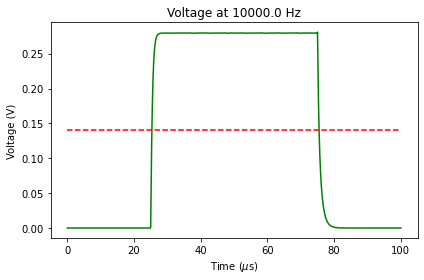

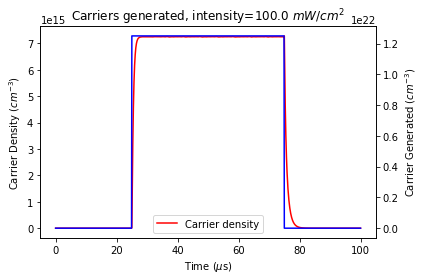

In [13]:
# Plot the result
device.plot(semilog=False)

### This simulates a single pulse

The top graph shows the voltage in *green*. The average voltage is in *red*. The voltage is calculated using some rough assumptions via Gauss's law, but in general it's based on the carrier density.

Again: **the red curve=left axis is the answer**. The blue curve is more for when we care about laser source rise times. That should be clear since 1e22 /cm^3 is unrealistically high for a perovskite, but 1e15 /cm^3 is pretty typical.

The bottom graph is what is *actually* being simulated. The blue curve represents the carriers generated (right axis). The red curve represents the actual carrier density (left axis). What is the difference? The red curve includes recombination. The blue curve is more relevant when you do complicated pulse trains, or add an actual rise time to your light pulse, and so on.

Let's make this more interesting and change up the lifetimes.

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Carriers generated, intensity=100.0 $mW/cm^2$'}, xlabel='Time ($\\mu$s)', ylabel='Carrier Density ($cm^{-3}$)'>)

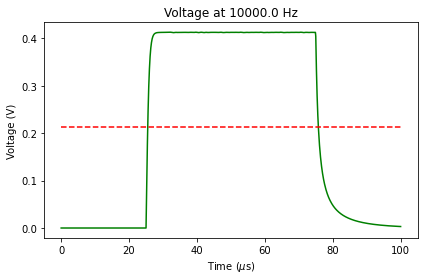

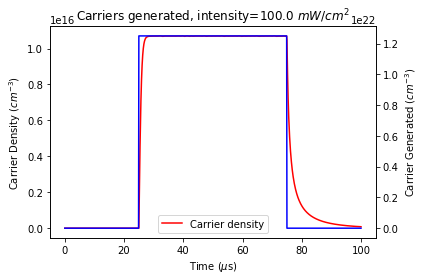

In [14]:
device.kinetics(k1=1e5, k2=1e-10,k3=0) #
device.simulate()
device.plot()

### What changed?

We changed ```k1``` to be 10^5 /s, which is ridiculous (10 microseconds!). But as a result, the carrier density is a magnitude higher, and we see slower relaxation because there are so many more carriers

Similarly, let's take the case of a much worse perovskite.

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Carriers generated, intensity=100.0 $mW/cm^2$'}, xlabel='Time ($\\mu$s)', ylabel='Carrier Density ($cm^{-3}$)'>)

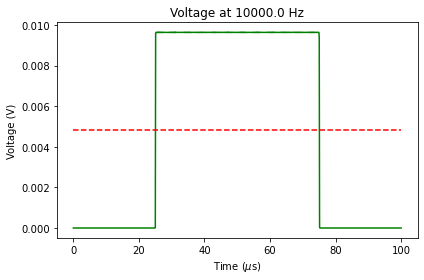

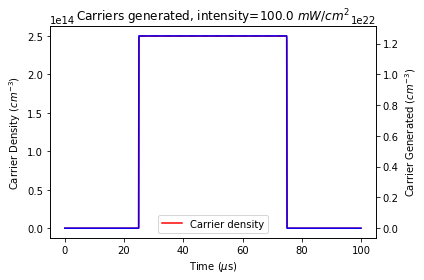

In [17]:
device.kinetics(k1=5e7, k2=1e-10,k3=0) #
device.simulate()
device.plot()

### What changed?

We changed ```k1``` to be 5e7 /s, which is quite bad (20 nanoseconds!). Now, the carriers saturate much more quickly because of the recombination rate being so high. These effects play a significant role in how IM-SKPM curves are generated.

There are other factors we could change, but they mostly just change the magnitude. For example, the intensity (```device.intensity```) doesn't really affect anything, except that it scales how many carriers are generated. ```intensity=0.1``` means 100 mW/cm^2 (1 Sun). Likewise, the ```wl (wavelength``` and ```NA (numerical aperture)``` are mostly there for calculating the area of excitation, but they aren't used directly in simulations.

C:\Users\raj\Documents\Coding\imskpm\imskpm\odes.py:68: RuntimeWarning: overflow encountered in power
  n_dot = g - k1 * n - k2 * n**2 - k3 * n**3
C:\Users\raj\Documents\Coding\imskpm\imskpm\odes.py:68: RuntimeWarning: invalid value encountered in multiply
  n_dot = g - k1 * n - k2 * n**2 - k3 * n**3


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Carriers generated, intensity=10000 $mW/cm^2$'}, xlabel='Time ($\\mu$s)', ylabel='Carrier Density ($cm^{-3}$)'>)

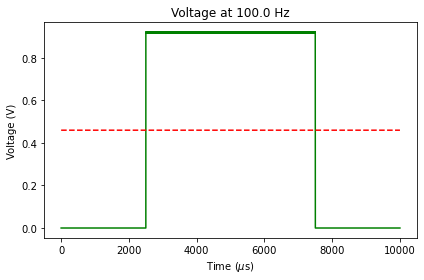

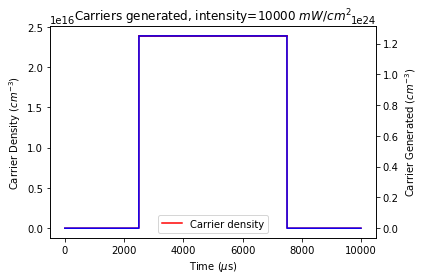

In [20]:
device.exc_source(intensity=10, wl=455e-9, NA=0.6)
device.make_pulse() # if we change the excitation, we shoud update the pulse
device.simulate()
device.plot()

### What changed?

We have 100X more intensity, so as a result the carrier density changed by quite a lot.


## Simulating a sweep

Here, we use the class ```IMSKPMSweep``` to probe a series of frequencies.
Some notes about this:

* very low frequencies require many points and are thus very slow to simulate. Fortunately, we also care the least about these
* you can set the frequencies explicitly that you wish to simulate

Let's go through a basic IM-SKPM curve and see the result.

<AxesSubplot:title={'center':'IMSKPM, intensity=100.0 $mW/cm^2$'}, xlabel='Frequency (Hz)', ylabel='Carrier Density ($cm^{-3}$)'>

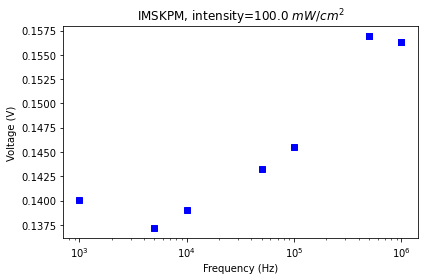

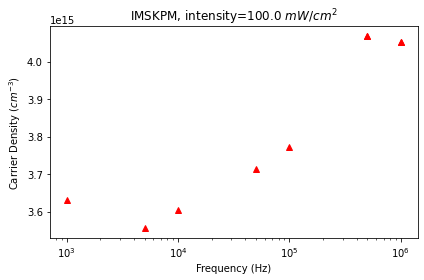

In [37]:
from imskpm.imskpmsweep import IMSKPMSweep
devicesweep = IMSKPMSweep(k1=1e6, k2=1e-10, k3=0)

# Let's update the default list (which is from 100 Hz to 80 MHz) to save time
import numpy as np
devicesweep.frequency_list = np.array([1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6, 5e5,1e6])
devicesweep.simulate_sweep(verbose=False) #verbose displays outputs to the command window for feedback
devicesweep.plot()

### What happened?

This completed a standard IMSKPM Sweep. If we want to change the simulation ODE function, we need to change ```devicesweep.func``` to another *valid* ODE. See ```odes.py``` file for more details. The default is the same used in standard simulations of PL lifetimes, for example.

The top plot is the voltage. Again, the voltage is calculated in a fairly crude manner using Gauss's law with a parallel plate capacitor. The bottom plot is the average carrier density from the simulations. Those two factors should be related.

Let's change some other parameters. The first one you might not think about is the lift height! To get around that, we can use a much lower lift height and get higher voltage values.

<AxesSubplot:title={'center':'IMSKPM, intensity=100.0 $mW/cm^2$'}, xlabel='Frequency (Hz)', ylabel='Carrier Density ($cm^{-3}$)'>

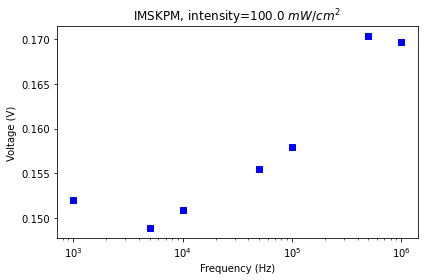

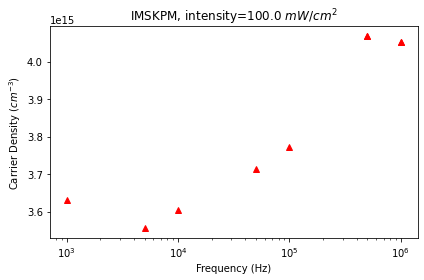

In [34]:
devicesweep.lift_height = 1e-9
devicesweep.simulate_sweep()
devicesweep.plot()

### What happened?

The change in lift height increased the voltage calculated in the top plot to increase by quite a lot, as would be expected.

Now, let's change the light intensity and see what happens.

C:\Users\raj\Documents\Coding\imskpm\imskpm\odes.py:68: RuntimeWarning: overflow encountered in power
  n_dot = g - k1 * n - k2 * n**2 - k3 * n**3
C:\Users\raj\Documents\Coding\imskpm\imskpm\odes.py:68: RuntimeWarning: invalid value encountered in multiply
  n_dot = g - k1 * n - k2 * n**2 - k3 * n**3


<AxesSubplot:title={'center':'IMSKPM, intensity=10000 $mW/cm^2$'}, xlabel='Frequency (Hz)', ylabel='Carrier Density ($cm^{-3}$)'>

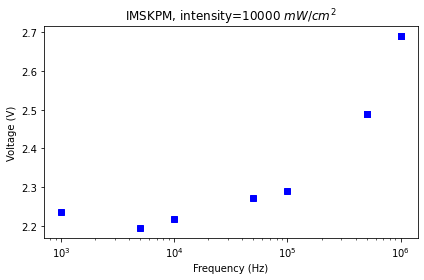

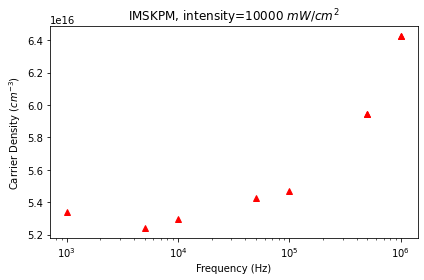

In [32]:
devicesweep.intensity=10
devicesweep.simulate_sweep()
devicesweep.plot()

### What happened?

The change in intensity shifted the IM-SKPM curve to the right, as makes sense given that we're shortening the lifetimes by having higher intensity. 

What about changing the recombination rate (we'll go back to lower intensity)

<AxesSubplot:title={'center':'IMSKPM, intensity=100.0 $mW/cm^2$'}, xlabel='Frequency (Hz)', ylabel='Carrier Density ($cm^{-3}$)'>

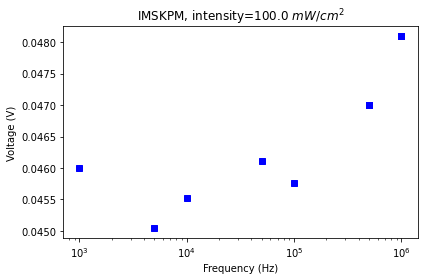

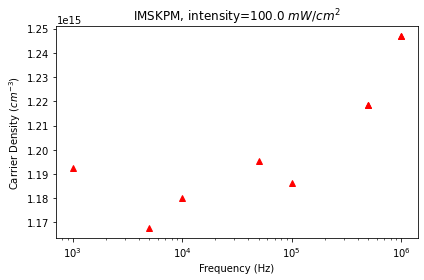

In [39]:
devicesweep.intensity=0.1
devicesweep.kinetics(k1=5e6, k2=1e-10, k3=0)
devicesweep.simulate_sweep(verbose=False)
devicesweep.plot()

### What happened?

The much higher ```k1``` results in significantly more recombination. This has the effect of lowering the carrier density, reducing the voltage (less charge on the bottom plate of the capacitor).

For much higher recombination rates, the simulation sweeps can get very noisy. So, there's a realistic range where we care about "good" perovskites that these seem to work well. 

We'll quickly try one that is much better (10 us lifetime) and we'll see that we start to get that build-up regime concern at higher frequencies.

<AxesSubplot:title={'center':'IMSKPM, intensity=100.0 $mW/cm^2$'}, xlabel='Frequency (Hz)', ylabel='Carrier Density ($cm^{-3}$)'>

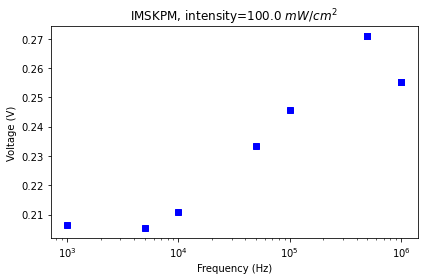

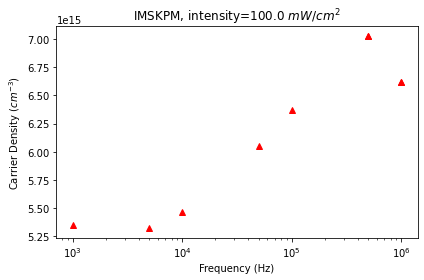

In [45]:
devicesweep.intensity=0.1
devicesweep.kinetics(k1=1e5, k2=1e-10, k3=0)
devicesweep.simulate_sweep(verbose=False)
devicesweep.plot()

### Where to go from here?

The most obvious is changing the simple rate equation to more complex ones, or explicitly including effects of generation in there. The other potential move is changing the simulation 